In [1]:
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
#data = Table.read('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits')
#JT PATH ON TRITON to training set after classification
#data = Table.read('/Users/johntimlin/Catalogs/QSO_candidates/Training_set/GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean_with_shenlabel.fits')
data = Table.read('/Users/johntimlin/Catalogs/QSO_candidates/Training_set/GTR-ADM-QSO-Trainingset-with-McGreer-VVDS-DR12Q_splitlabel.fits')

#JT PATH HOME USE SHEN ZCUT
#data = Table.read('/home/john/Catalogs/QSO_Candidates/Training_set/GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean_with_shenlabel.fits')


#data = data.filled()
# Remove stars
qmask = (data['zspec']>0)
qdata = data[qmask]
print len(qdata)

# X is in the format need for all of the sklearn tools, it just has the colors
#Xtrain = np.vstack([ qdata['ug'], qdata['gr'], qdata['ri'], qdata['iz'], qdata['zs1'], qdata['s1s2']]).T
#Xtrain = np.vstack([np.asarray(qdata[name]) for name in ['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2']]).T
Xtrain = np.vstack([np.asarray(qdata[name]) for name in ['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2']]).T
#y = np.array(data['labels'])
ytrain = np.array(qdata['zspec'])

241752


In [17]:
# For algorithms that need scaled data:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
XStrain = scaler.fit_transform(Xtrain)  # Don't cheat - fit only on training data

In [11]:
# TEST DATA USING 2.9<z<5.4 zrange ON HOME
testdata = Table.read('/Users/johntimlin/Catalogs/QSO_candidates/Training_set/GTR-ADM-QSO-Trainingset-with-McGreer-VVDS-DR12Q_splitlabel.fits')
#testdata = Table.read('./catalogs/HZ_forphotoz.fits')

In [12]:
#Limit to objects that have been classified as quasars
#qsocandmask = ((testdata['ypredRFC']==0) | (testdata['ypredSVM']==0) | (testdata['ypredBAG']==0))
qsocandmask = (testdata['zspec'] >= 2.9)
testdatacand = testdata[qsocandmask]
print len(testdata),len(testdatacand)

#Xtest = np.vstack([ testdatacand['ug'], testdatacand['gr'], testdatacand['ri'], testdatacand['iz'], testdatacand['zs1'], testdatacand['s1s2']]).T
Xtest = np.vstack([np.asarray(testdatacand[name]) for name in ['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2']]).T 
XStest = scaler.transform(Xtest)  # apply same transformation to test data

700894 22752


In [7]:
#Fit the unscaled data using NW
import numpy as np
from astroML.linear_model import NadarayaWatson
model = NadarayaWatson('gaussian', 0.05)
model.fit(Xtrain,ytrain)


from dask import compute, delayed
def process(Xin):
    return model.predict(Xin)

# Create dask objects
dobjs = [delayed(process)(x.reshape(1,-1)) for x in Xtest]



import dask.threaded
ypred = compute(*dobjs, get=dask.threaded.get)


# The dask output needs to be reformatted.
zphotNW = np.array(ypred).reshape(1,-1)[0]
testdatacand['zphotNW'] = zphotNW


In [8]:
#Fit the unscaled data using RF
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor()
modelRF.fit(Xtrain,ytrain)

zphotRF = modelRF.predict(Xtest)
testdatacand['zphotRF'] = zphotRF

In [18]:
print np.shape(XStest), np.shape(Xtest)
print np.shape(XStrain), np.shape(Xtrain)


(22752, 6) (22752, 6)
(241752, 6) (241752, 6)


In [19]:
#Fit the scaled data using NW
import numpy as np
from astroML.linear_model import NadarayaWatson
model = NadarayaWatson('gaussian', 0.05)
model.fit(XStrain,ytrain)


from dask import compute, delayed
def process(Xin):
    return model.predict(Xin)

# Create dask objects
dobjs = [delayed(process)(x.reshape(1,-1)) for x in XStest]



import dask.threaded
ypred = compute(*dobjs, get=dask.threaded.get)


# The dask output needs to be reformatted.
zphotNWS = np.array(ypred).reshape(1,-1)[0]
testdatacand['zphotNWS'] = zphotNWS


In [20]:
#Fit the unscaled data using RF
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor()
modelRF.fit(XStrain,ytrain)

zphotRFS = modelRF.predict(XStest)
testdatacand['zphotRFS'] = zphotRFS

In [ ]:
#Write the data to file
#testdatacand.write('./HZ_wphotoz.fits')

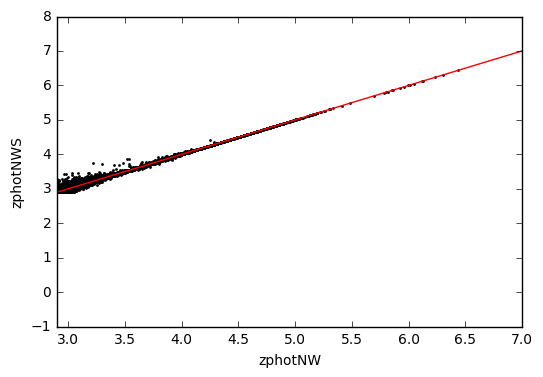

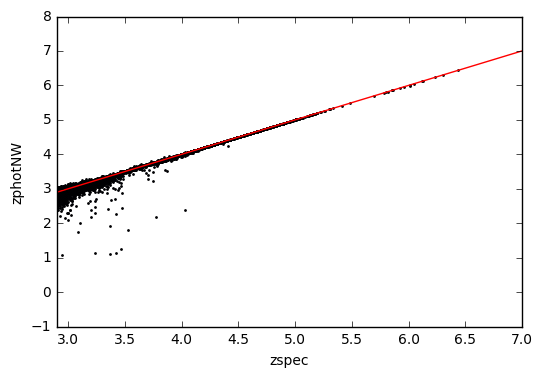

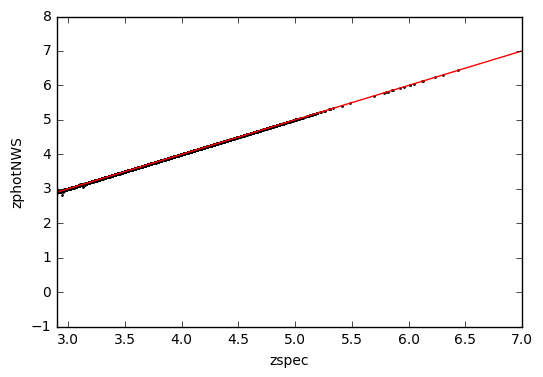

In [47]:
x = np.linspace(0,7,10)
plt.figure(1)
plt.scatter(zphotNW,zphotNWS,s=1)
plt.plot(x,x,c='r')
plt.xlabel('zphotNW')
plt.ylabel('zphotNWS')
plt.xlim(2.9,7)
plt.figure(2)
plt.scatter(data['zspec'][qsocandmask],zphotNW,s=1)
plt.plot(x,x,c='r')
plt.xlabel('zspec')
plt.ylabel('zphotNW')
plt.xlim(2.9,7)
plt.figure(3)
plt.scatter(data['zspec'][qsocandmask],zphotNWS,s=1)
plt.plot(x,x,c='r')
plt.xlabel('zspec')
plt.ylabel('zphotNWS')
plt.xlim(2.9,7)
plt.show()

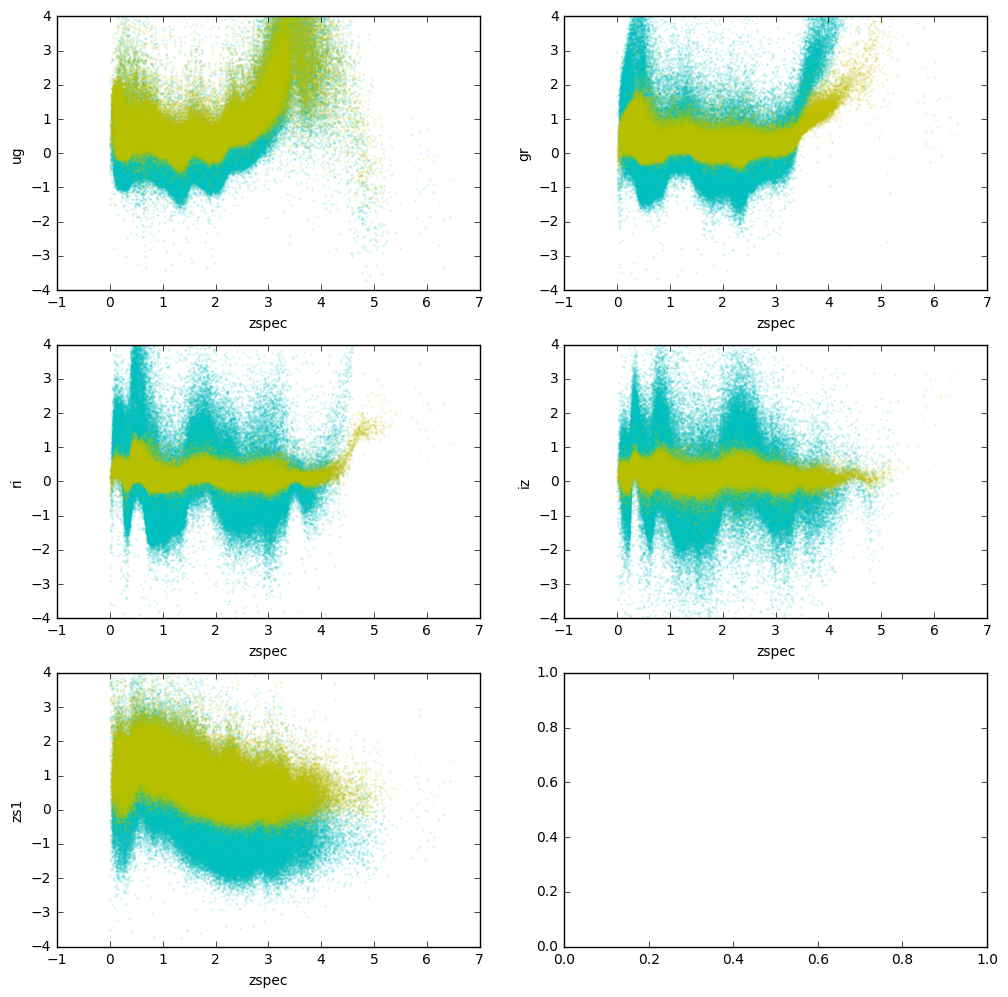

In [44]:
#Plot the scaled and unscaled colors
import matplotlib.gridspec as gridspec


fig = plt.figure(1,figsize = (12,12))

gs = gridspec.GridSpec(3,2)#,width_ratios = [1,1,1,1,1,1], height_ratios = [1,1,1,1,1,1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

for i in range(5):
    name = [ax0,ax1,ax2,ax3,ax4,ax5]
    lab = ['ug','gr','ri','iz','zs1','s1s2']
    plt.axes(name[i])
    plt.scatter(ytrain,XStrain[:,i],s=1,alpha=0.1,color = 'c')
    plt.scatter(ytrain,Xtrain[:,i],s=1,alpha=0.1,color = 'y')
    #plt.scatter(XStrain[:,i],XStrain[:,i+1],s=1,alpha=1,color = 'c')
    #plt.scatter(XStest[:,i],XStest[:,i+1],s=1,alpha=0.5,color = 'r')
    #plt.scatter(XStest[:,i],XStest[:,i+1],s=1,alpha=1,color = 'y')
    plt.xlabel('zspec')
    plt.ylabel(lab[i])
    plt.ylim(-4,4)

plt.show()


In [75]:
#Do the cross validation
data = Table.read('/Users/johntimlin/Catalogs/QSO_candidates/Training_set/GTR-ADM-QSO-Trainingset-with-McGreer-VVDS-DR12Q_splitlabel.fits')

#JT PATH HOME USE SHEN ZCUT
#data = Table.read('/home/john/Catalogs/QSO_Candidates/Training_set/GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean_with_shenlabel.fits')


#data = data.filled()
# Remove stars
qmask = (data['zspec']>0)
qdata = data[qmask]
print len(qdata)

# X is in the format need for all of the sklearn tools, it just has the colors
#Xtrain = np.vstack([ qdata['ug'], qdata['gr'], qdata['ri'], qdata['iz'], qdata['zs1'], qdata['s1s2']]).T
#Xtrain = np.vstack([np.asarray(qdata[name]) for name in ['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2']]).T
Xtrain = np.vstack([np.asarray(qdata[name]) for name in ['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2']]).T
#y = np.array(data['labels'])
ytrain = np.array(qdata['zspec'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
XStrain = scaler.fit_transform(Xtrain)  # Don't cheat - fit only on training data


241748


In [76]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report

# Split the training data into training and test sets for cross-validation
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=42)

# Do the same for the scaled data sets
XStrain2, XStest2, yStrain2, yStest2 = train_test_split(XStrain, ytrain, test_size=0.25, random_state=42)

In [77]:
#Compute NW for unscaled data
import numpy as np
from astroML.linear_model import NadarayaWatson
model = NadarayaWatson('gaussian', 0.05)
model.fit(Xtrain2,ytrain2)


from dask import compute, delayed
def process(Xin):
    return model.predict(Xin)

# Create dask objects
dobjs = [delayed(process)(x.reshape(1,-1)) for x in Xtest2]



import dask.threaded
ypred = compute(*dobjs, get=dask.threaded.get)


# The dask output needs to be reformatted.
zphotNWc = np.array(ypred).reshape(1,-1)[0]


In [78]:
#Compute NW for scaled data
import numpy as np
from astroML.linear_model import NadarayaWatson
model = NadarayaWatson('gaussian', 0.05)
model.fit(XStrain2,yStrain2)


from dask import compute, delayed
def process(Xin):
    return model.predict(Xin)

# Create dask objects
dobjs = [delayed(process)(x.reshape(1,-1)) for x in XStest2]



import dask.threaded
ypreds = compute(*dobjs, get=dask.threaded.get)


# The dask output needs to be reformatted.
zphotNWSc = np.array(ypreds).reshape(1,-1)[0]


In [116]:
D = ytest2-zphotNWc
d = yStest2-zphotNWSc
bins = np.linspace(-4,4,50)

idx = np.where(np.isnan(d) == False)
print len(idx[0])
print yStest2[idx[0]]
print len(yStest2[~idx[0]])

60361
[ 1.60810006  2.2434001   0.9465     ...,  2.2579999   0.3678      0.84299999]
60361


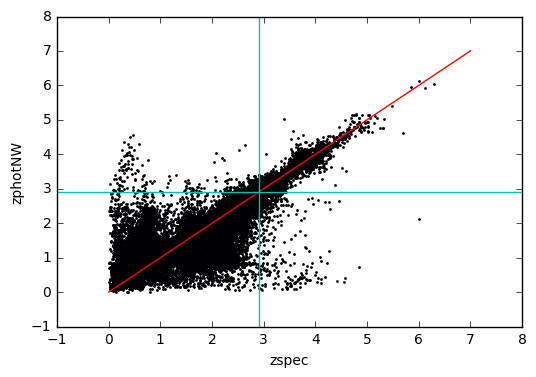

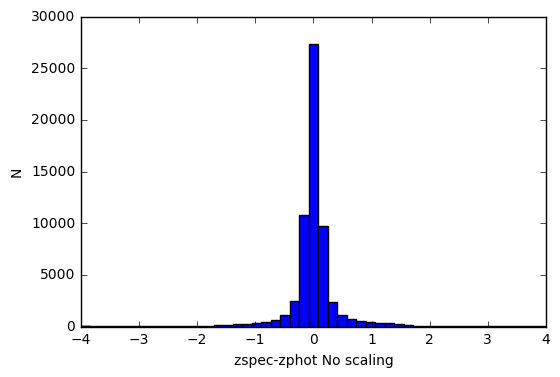

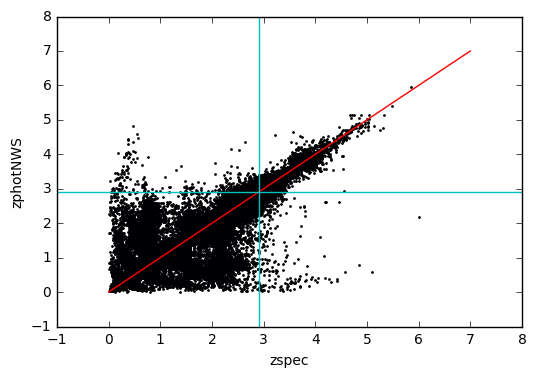

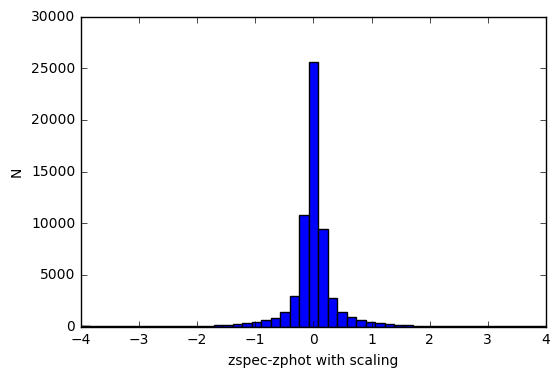

In [149]:
x = np.linspace(0,7,10)

plt.figure(2)
plt.scatter(ytest2,zphotNWc,s=1)
plt.plot(x,x,c='r')
plt.axhline(2.9,c = 'c')
plt.axvline(2.9, c='c')
plt.xlabel('zspec')
plt.ylabel('zphotNW')
#plt.xlim(2.9,7)

plt.figure(3)
plt.hist(ytest2-zphotNWc,bins =bins)
plt.xlabel('zspec-zphot No scaling')
plt.ylabel('N')



plt.figure(4)
plt.scatter(yStest2[idx[0]],zphotNWSc[idx[0]],s=1)
plt.plot(x,x,c='r')
plt.axhline(2.9,c = 'c')
plt.axvline(2.9, c='c')
plt.xlabel('zspec')
plt.ylabel('zphotNWS')
#plt.xlim(2.9,7)

plt.figure(10)
plt.hist(d[idx[0]],bins =bins)
plt.xlabel('zspec-zphot with scaling')
plt.ylabel('N')
plt.show()

In [156]:
bad = (ytest2<=2.9) & (zphotNWc >= 2.9)
miss = (ytest2>=2.9) & (zphotNWc <= 2.9)

print len(ytest2[bad])
print len(ytest2[miss])

print len(ytest2[ytest2>=2.9])

print 'contam', len(ytest2[bad])*1.0/len(ytest2[zphotNWc>=2.9])
print 'miss', len(ytest2[miss])*1.0/len(ytest2[ytest2>=2.9])


701
802
5621
contam 0.127015763725
miss 0.14267923857


In [120]:
#Fit the unscaled data using RF
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor()
modelRF.fit(Xtrain2,ytrain2)

zphotRFc = modelRF.predict(Xtest2)

#RF on scaled
modelRF = RandomForestRegressor()
modelRF.fit(XStrain2,ytrain2)

zphotRFSc = modelRF.predict(XStest2)


In [121]:
D = ytest2-zphotRFc
d = yStest2-zphotRFSc
bins = np.linspace(-4,4,50)

idx = np.where(np.isnan(d) == False)
print len(idx[0])


60437


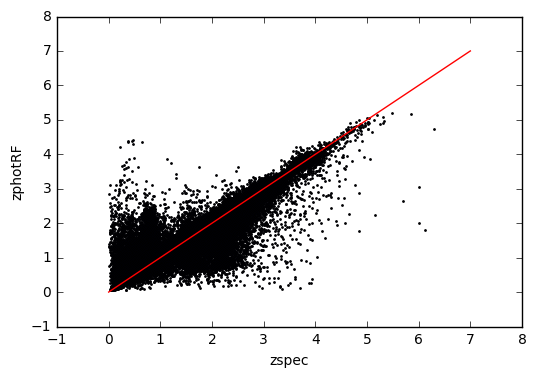

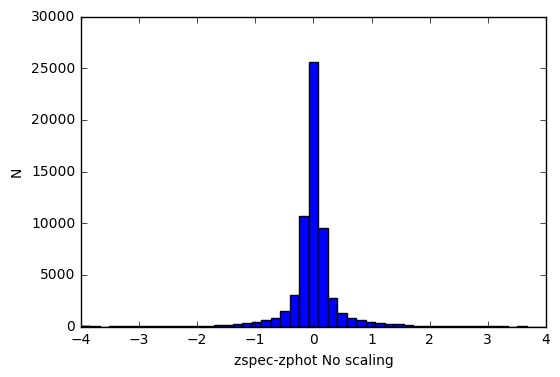

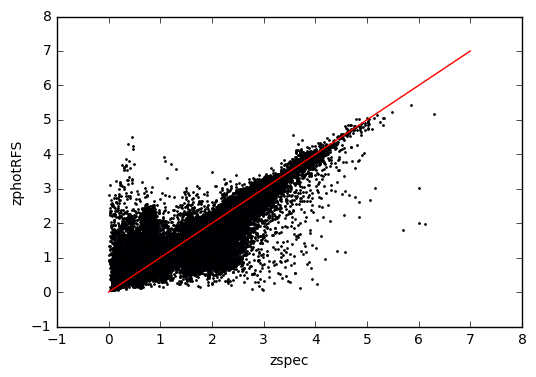

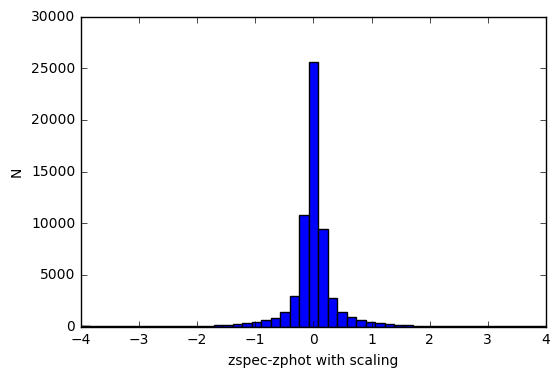

In [123]:
x = np.linspace(0,7,10)

plt.figure(2)
plt.scatter(ytest2,zphotRFc,s=1)
plt.plot(x,x,c='r')
plt.xlabel('zspec')
plt.ylabel('zphotRF')
#plt.xlim(2.9,7)

plt.figure(3)
plt.hist(ytest2-zphotRFc,bins =bins)
plt.xlabel('zspec-zphot No scaling')
plt.ylabel('N')


plt.figure(4)
plt.scatter(yStest2[idx[0]],zphotRFSc[idx[0]],s=1)
plt.plot(x,x,c='r')
plt.xlabel('zspec')
plt.ylabel('zphotRFS')
#plt.xlim(2.9,7)

plt.figure(10)
plt.hist(d[idx[0]],bins =bins)
plt.xlabel('zspec-zphot with scaling')
plt.ylabel('N')
plt.show()

In [124]:
## Above are not great... Try bootstrap aggregation?


In [138]:
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(max_samples=0.5, max_features=1.0, random_state=42, n_jobs=1)
bagS = BaggingRegressor(max_samples=0.5, max_features=1.0, random_state=42, n_jobs=1)

bag.fit(Xtrain2,ytrain2)
bagS.fit(XStrain2,yStrain2)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=0.5,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
         verbose=0, warm_start=False)

In [150]:
#Predict using the fit algorithm
val = bag.predict(Xtest2)
valS = bagS.predict(XStest2)

bad = (ytest2<=2.9) & (val >= 2.9)
miss = (ytest2>=2.9) & (val <= 2.9)

print len(ytest2[bad])
print len(ytest2[miss])

print len(ytest2[ytest2>=2.9])

print 'contam', len(ytest2[bad])*1.0/len(ytest2[ytest2>=2.9])
print 'miss', len(ytest2[miss])*1.0/len(ytest2[ytest2>=2.9])

562
935
5621
contam 0.0999822095713
miss 0.166340508806


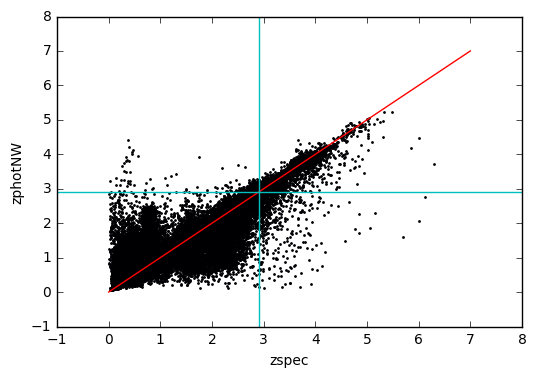

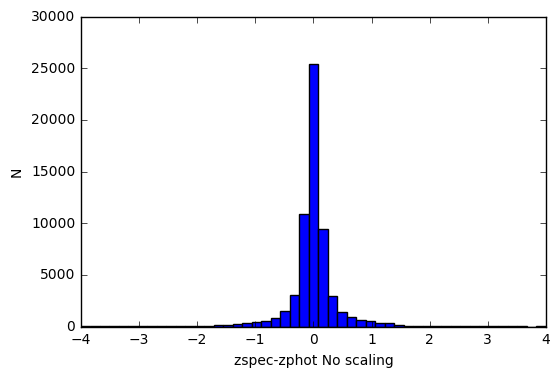

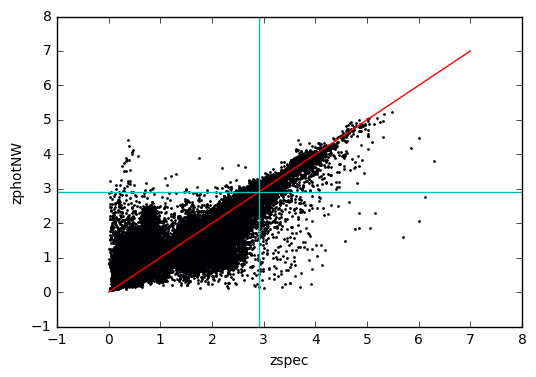

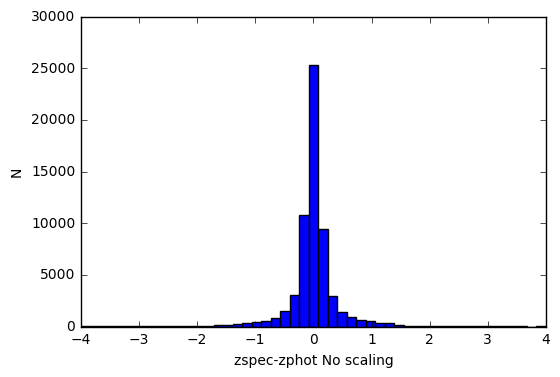

In [141]:
x = np.linspace(0,7,10)

plt.figure(2)
plt.scatter(ytest2,val,s=1)
plt.plot(x,x,c='r')
plt.axhline(2.9,c = 'c')
plt.axvline(2.9, c='c')
plt.xlabel('zspec')
plt.ylabel('zphotNW')
#plt.xlim(2.9,7)

plt.figure(3)
plt.hist(ytest2-val,bins =bins)
plt.xlabel('zspec-zphot No scaling')
plt.ylabel('N')

plt.figure(4)
plt.scatter(ytest2,valS,s=1)
plt.plot(x,x,c='r')
plt.axhline(2.9,c = 'c')
plt.axvline(2.9, c='c')
plt.xlabel('zspec')
plt.ylabel('zphotNW')
#plt.xlim(2.9,7)

plt.figure(5)
plt.hist(ytest2-valS,bins =bins)
plt.xlabel('zspec-zphot No scaling')
plt.ylabel('N')

In [151]:
#Try KNN?

from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

bagk = BaggingRegressor(KNeighborsRegressor(n_neighbors = 7),max_samples=0.5, max_features=1.0, random_state=42, n_jobs=1)
bagkS = BaggingRegressor(KNeighborsRegressor(n_neighbors = 7),max_samples=0.5, max_features=1.0, random_state=42, n_jobs=1)

bagk.fit(Xtrain2,ytrain2)
bagkS.fit(XStrain2,yStrain2)

BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [153]:
#Predict using the fit algorithm
val = bagk.predict(Xtest2)
valS = bagkS.predict(XStest2)

bad = (ytest2<=2.9) & (val >= 2.9)
miss = (ytest2>=2.9) & (val <= 2.9)

print len(ytest2[bad])
print len(ytest2[miss])

print len(ytest2[ytest2>=2.9])

print 'contam', len(ytest2[bad])*1.0/len(ytest2[ytest2>=2.9])
print 'miss', len(ytest2[miss])*1.0/len(ytest2[ytest2>=2.9])

531
844
5621
contam 0.094467176659
miss 0.150151218644


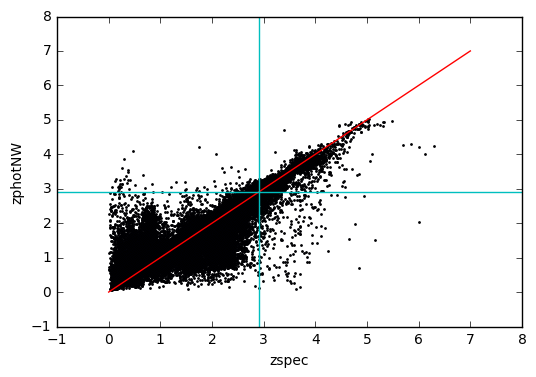

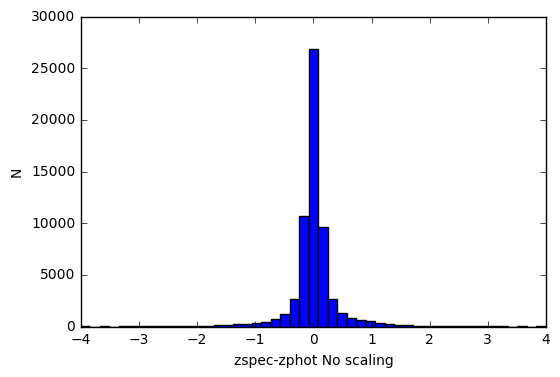

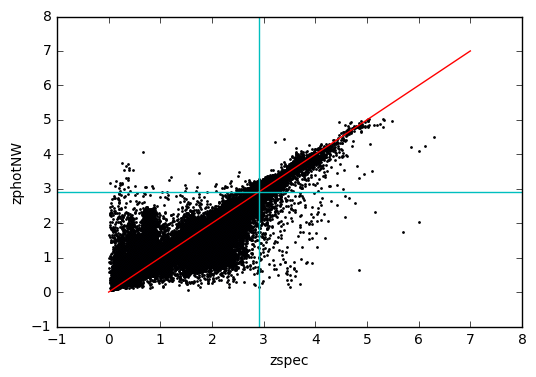

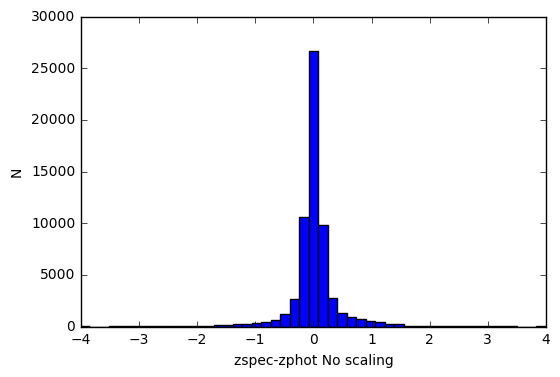

In [154]:
x = np.linspace(0,7,10)

plt.figure(2)
plt.scatter(ytest2,val,s=1)
plt.plot(x,x,c='r')
plt.axhline(2.9,c = 'c')
plt.axvline(2.9, c='c')
plt.xlabel('zspec')
plt.ylabel('zphotNW')
#plt.xlim(2.9,7)

plt.figure(3)
plt.hist(ytest2-val,bins =bins)
plt.xlabel('zspec-zphot No scaling')
plt.ylabel('N')

plt.figure(4)
plt.scatter(ytest2,valS,s=1)
plt.plot(x,x,c='r')
plt.axhline(2.9,c = 'c')
plt.axvline(2.9, c='c')
plt.xlabel('zspec')
plt.ylabel('zphotNW')
#plt.xlim(2.9,7)

plt.figure(5)
plt.hist(ytest2-valS,bins =bins)
plt.xlabel('zspec-zphot No scaling')
plt.ylabel('N')

In [155]:
#Try KNN?

from sklearn.ensemble import BaggingRegressor
from astroML.linear_model import NadarayaWatson

bagk = BaggingRegressor(NadarayaWatson,max_samples=0.5, max_features=1.0, random_state=42, n_jobs=1)
#bagkS = BaggingRegressor(KNeighborsRegressor(n_neighbors = 7),max_samples=0.5, max_features=1.0, random_state=42, n_jobs=1)

bagk.fit(Xtrain2,ytrain2)
#bagkS.fit(XStrain2,yStrain2)

TypeError: Cannot clone object '<class 'astroML.linear_model.kernel_regression.NadarayaWatson'>' (type <type 'type'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.